# Data Cleaning and Exploration

## Initialization

In [1]:
#Python Data Analysis imports
import pandas as pd
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#To grab stock data
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
from datetime import datetime as dt
import datetime
import calendar

# Caching
import requests_cache

In [10]:
stock_names = {'AAL': 'American Airlines Group Inc.', 'DAL': 'Delta Air Lines, Inc.', 'FB': 'Facebook', 'GOOGL': 'Google'}
stocks = ['AAL', 'DAL', 'FB', 'GOOGL']
AAL, DAL, FB, GOOGL = None, None, None, None
start = dt(2013, 1, 1)
end = dt(2019, 12, 31)

Making the same request repeatedly can use a lot of bandwidth, slow down your code and may result in your IP being banned.
We might not need to cache...

In [11]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [12]:
def load_stocks(stocks, start, end):
    """
    Loads stock data from Yahoo Finance.
    """
    for stock in stocks:
        try:
            globals()[stock] = web.DataReader(stock, 'yahoo', start, end, session=session) # default interval is 1day
        except Exception as  e:
            print('Error downloading: ' + stock, "error: ", e)
            return
    print('Data loaded successfully.')

In [13]:
load_stocks(stocks, start, end)

Data loaded successfully.


## Data Cleaning

Features - Airline Stocks:
- High - High price of the stock
- Low - Low price of the stock
- Open - Open price of the stock
- Close - Close price of the stock
- Volume - Volume of the stock

In [14]:
print(AAL.shape)
AAL.head()

(1762, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,14.01,13.60,13.72,13.98,6662000.0,13.179527
2013-01-03,14.13,13.60,14.02,13.66,5398400.0,12.877845
2013-01-04,14.87,13.76,13.80,14.73,12048300.0,13.886580
2013-01-07,14.98,14.53,14.79,14.84,5730600.0,13.990283
2013-01-08,15.25,14.78,14.89,15.16,8034400.0,14.291960


In [15]:
print(DAL.shape)
print(FB.shape)
print(GOOGL.shape)

(1762, 6)
(1762, 6)
(1762, 6)


Check for missing values

In [16]:
def show_stock_missing_values():
    missing_values = pd.DataFrame(index=["High", "Low", "Open", "Close", "Volume"], columns=stocks)
    for stock in stocks:
        missing_values[stock] = globals()[stock].isnull().sum()
    return missing_values

show_stock_missing_values()

,AAL,DAL,FB,GOOGL
High,0,0,0,0
Low,0,0,0,0
Open,0,0,0,0
Close,0,0,0,0
Volume,0,0,0,0


In [17]:
def stock_extract_dates():
    for stock in stocks:
        df_stock = globals()[stock]
        df_stock['Day'], df_stock['Month'], df_stock['Year'] = df_stock.index.day, df_stock.index.month, df_stock.index.year

stock_extract_dates()
AAL.head(2)

,High,Low,Open,Close,Volume,Adj Close,Day,Month,Year
Date,,,,,,,,,
2013-01-02,14.01,13.6,13.72,13.98,6662000.0,13.179527,2,1,2013
2013-01-03,14.13,13.6,14.02,13.66,5398400.0,12.877845,3,1,2013


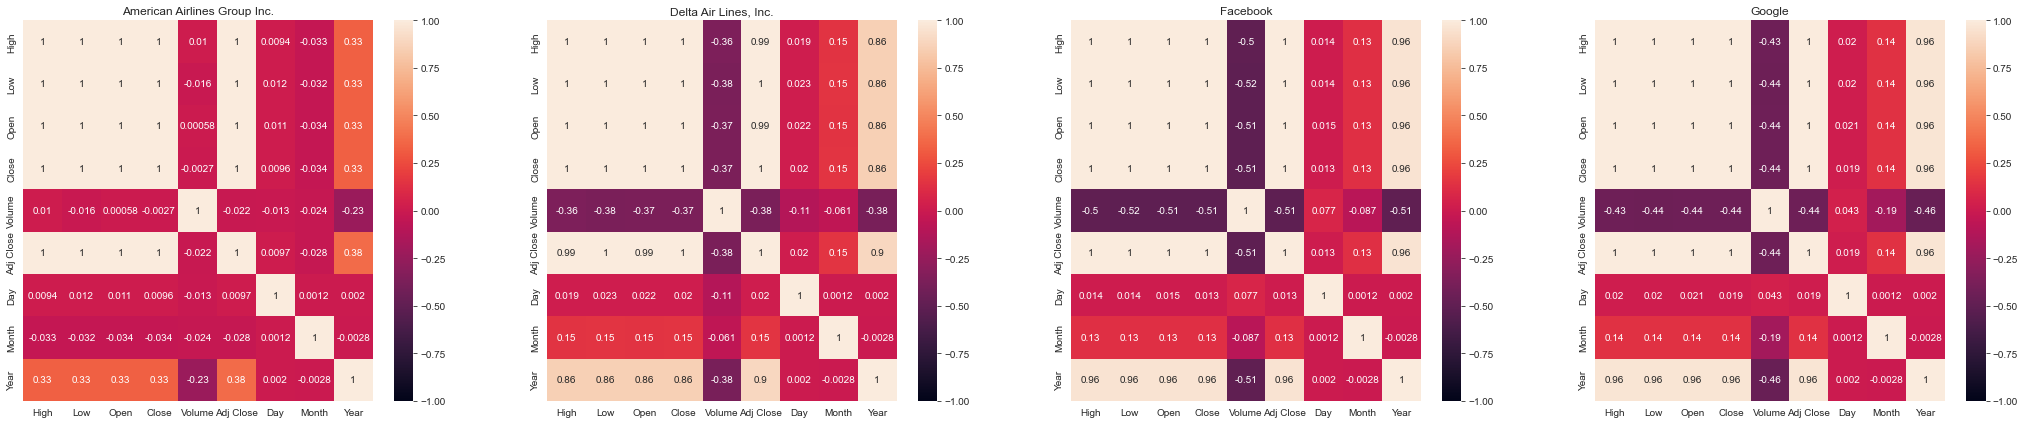

In [19]:
def stocks_corr():
    fig, ax = plt.subplots(1, len(stocks), figsize=(9*len(stocks), 7))
    for i, stock in enumerate(stocks):
        ax[i].set_title(stock_names[stock])
        sns.heatmap(globals()[stock].corr(), vmin=-1, vmax=1,  ax=ax[i], annot=True)

stocks_corr()

## Exploratory Data Analysis

In [26]:
def plot_feature_per_stock(features, years):
	fig, ax = plt.subplots(1, len(stocks), figsize=(7*len(stocks), 6))
	for i, stock in enumerate(stocks):
			df_stock = globals()[stock]
			df_stock = df_stock.loc[df_stock["Year"].isin(years)]

			ax[i].set_title(stock_names[stock] + " - " + ",".join(str(year) for year in years))
			df_stock.plot(y=features, ax=ax[i], label=[f"{stock} - {f}" for f in features])

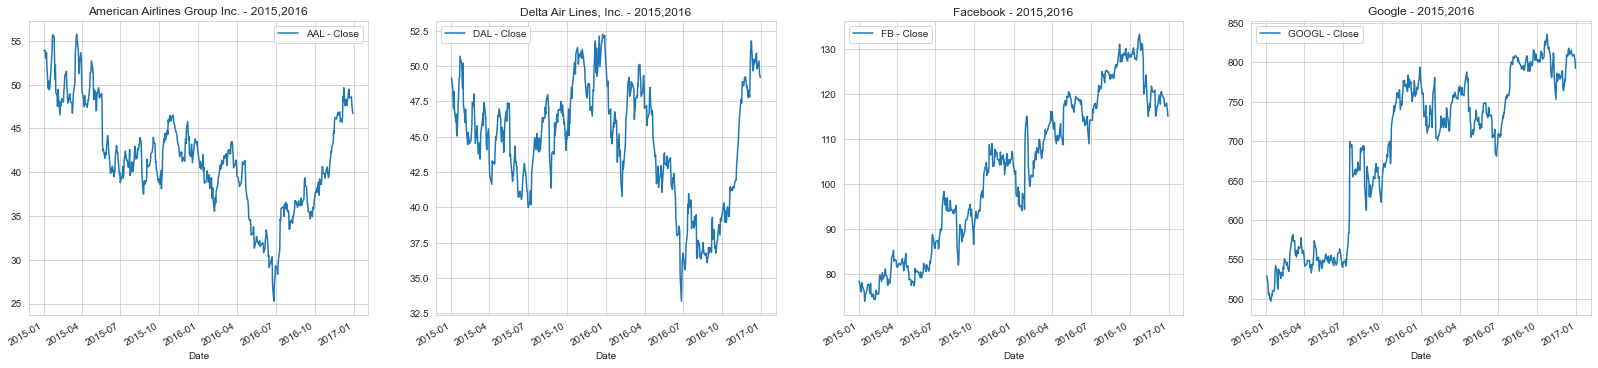

In [27]:
plot_feature_per_stock(["Close"], [2015, 2016])

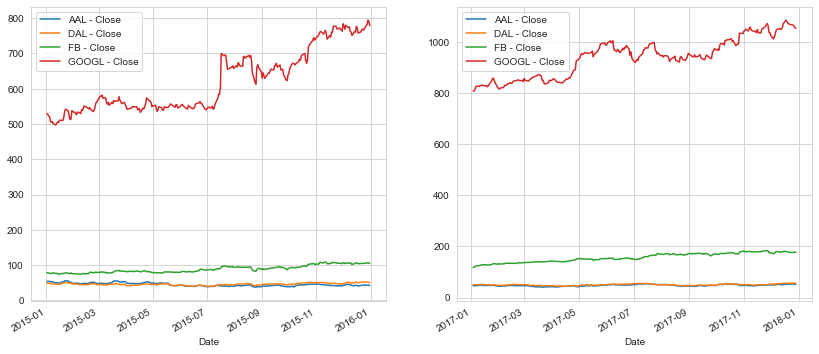

In [30]:
def plot_stock_feature_per_year(features:list = ['Open'], years:list = [2015]):
    fig, ax = plt.subplots(1, len(years), figsize=(7*len(years), 6))
    for i, year in enumerate(years):
        for j, stock in enumerate(stocks):
            df_stock = globals()[stock]
            df_stock = df_stock.loc[df_stock["Year"] == year]

            df_stock.plot(y=features, ax=ax[i], label=[f"{stock} - {f}" for f in features])

plot_stock_feature_per_year(features=['Close'], years=[2015, 2017])

### Seasonality and Trend - Analysis

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
def stock_seasonality_and_trends_decompose(feature='Open', method='classical', model='additive', freq='B', period=1, years=[2015, 2016]):
    fig, ax = plt.subplots(4, len(stocks), figsize=(25, 20))
    for i, stock in enumerate(stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]
        df_stock = df_stock.asfreq(freq).dropna()
        df_stock_decompose = None
        decompostion = []

        if method == 'classical':
            df_stock_decompose = seasonal_decompose(df_stock[feature], model=model, period=period)
        elif method == 'STL':
            df_stock_decompose = STL(df_stock[feature], seasonal=13, period=period).fit()
        
        if df_stock_decompose == None:
            print('Error decomposing: ' + stock)
            return

        
        ax[0, i].plot(df_stock[feature])
        ax[0, i].set_title(f"Observed - ({stock_names[stock]})")
        ax[0, i].tick_params(axis='x', labelrotation=45)

        ax[1, i].plot(df_stock_decompose.trend)
        ax[1, i].set_title(f"Trend - ({stock_names[stock]})")
        ax[1, i].tick_params(axis='x',labelrotation=45)

        ax[2, i].plot(df_stock_decompose.seasonal)
        ax[2, i].set_title(f"Seasonal - ({stock_names[stock]})")
        ax[2, i].tick_params(axis='x',labelrotation=45)

        resid_mu = df_stock_decompose.resid.mean()
        resid_dev = df_stock_decompose.resid.std()

        lower = resid_mu - 3*resid_dev
        upper = resid_mu + 3*resid_dev

        anomalies = df_stock[feature][(df_stock_decompose.resid < lower) | (df_stock_decompose.resid > upper)]

        ax[3, i].plot(df_stock_decompose.resid)
        ax[3, i].fill_between([dt(min(years),1,1), dt(max(years)+1,1,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
        ax[3, i].set_title(f"Residual - ({stock_names[stock]})")
        ax[3, i].tick_params(axis='x',labelrotation=45)


        # adjusting positions of the subplots
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        
        decompostion.append((stock, df_stock_decompose, anomalies))


In [32]:
years = list(range(start.year, end.year + 1))
periods = [year for year in AAL.index.year.value_counts()]
period = np.mean(periods).astype(int)
period

251

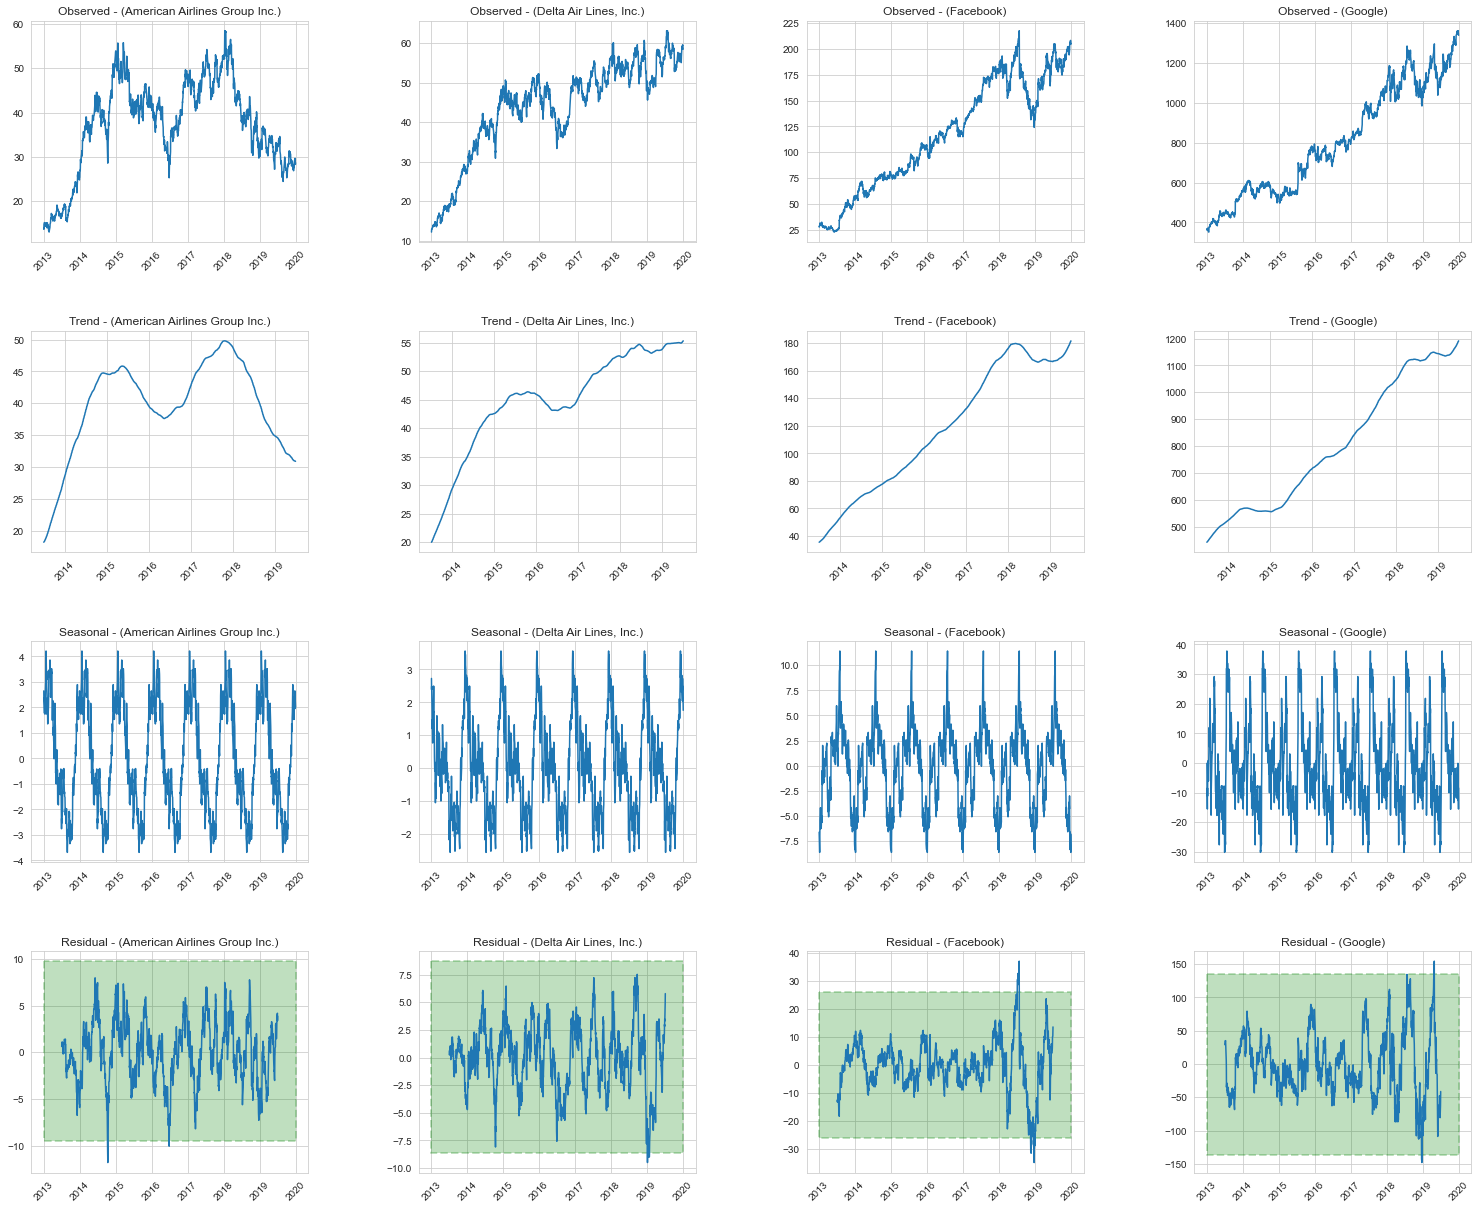

In [36]:
decompose_res_classical = stock_seasonality_and_trends_decompose("Close", model="additive", method='classical', freq="B", period=period, years=years)

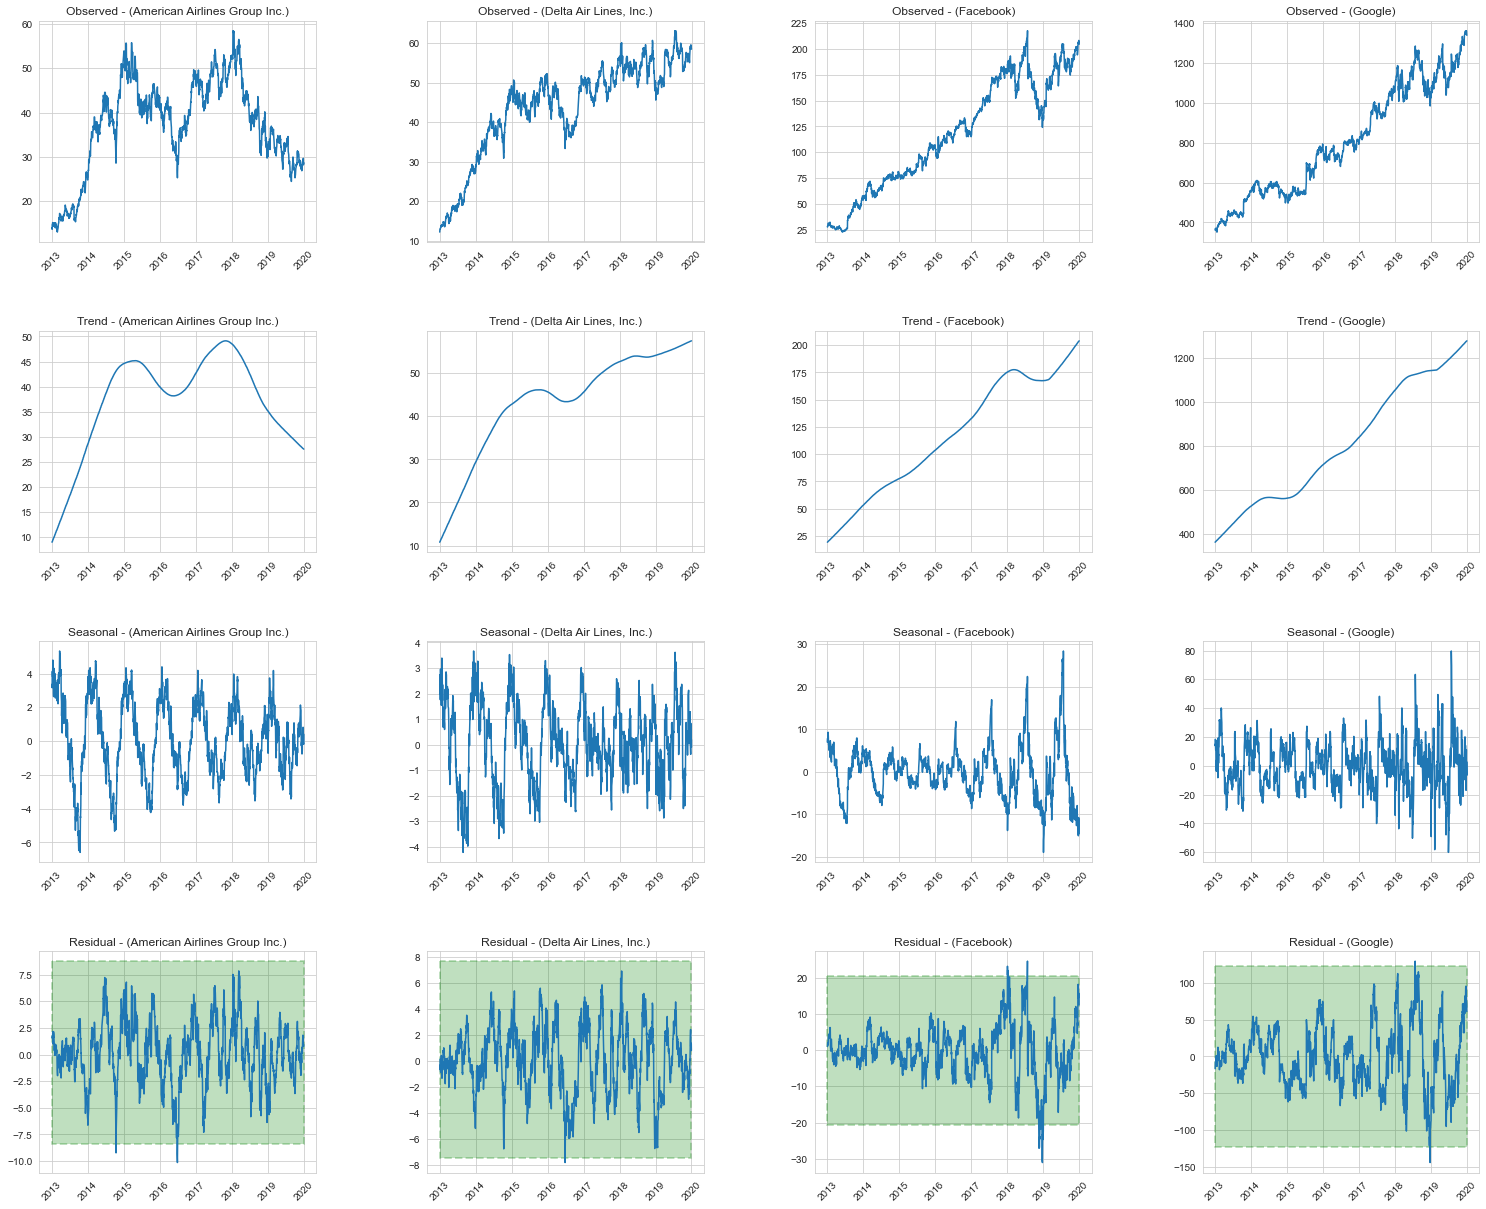

In [37]:
decompose_res_STL = stock_seasonality_and_trends_decompose("Close", model="additive", method='STL', freq="B", period=period, years=years)

Time series looks like its seasonal, we will check by performing (Augmented Dickey-Fuller) test and KPSS (Kwiatkowski–Phillips–Schmidt–Shintests) tests

Fjerne anomolies?

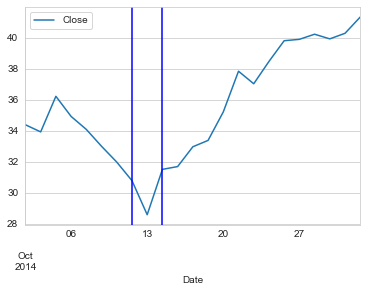

In [89]:
AAL.loc[(AAL["Year"] == 2014) & (AAL["Month"] == 10)].plot(y=["Close"])
plt.axvline(x=dt(2014, 10, 10), color='b', label='axvline - full height')
plt.axvline(x=dt(2014, 10, 14), color='b', label='axvline - full height')

### Stationarity - Analysis

ADF - Null Hypothesis: Not Stationary
Kpss - Null Hypothesis: Stationary


,AAL-ADF,AAL-KPSS,DAL-ADF,DAL-KPSS,FB-ADF,FB-KPSS,GOOGL-ADF,GOOGL-KPSS
Test,ADF,KPSS,ADF,KPSS,ADF,KPSS,ADF,KPSS
ADF/Kpss,-2.437025,1.590304,-2.378492,5.061722,-0.950889,6.327552,-0.287025,6.441195
p-value,0.131558,0.01,0.147899,0.01,0.770753,0.01,0.927322,0.01
C-1%,-3.434071,0.739,-3.434069,0.739,-3.434069,0.739,-3.434092,0.739
C-5%,-2.863184,0.463,-2.863183,0.463,-2.863183,0.463,-2.863193,0.463
C-10%,-2.567645,0.347,-2.567645,0.347,-2.567645,0.347,-2.56765,0.347
C-2.5%,-,0.574,-,0.574,-,0.574,-,0.574


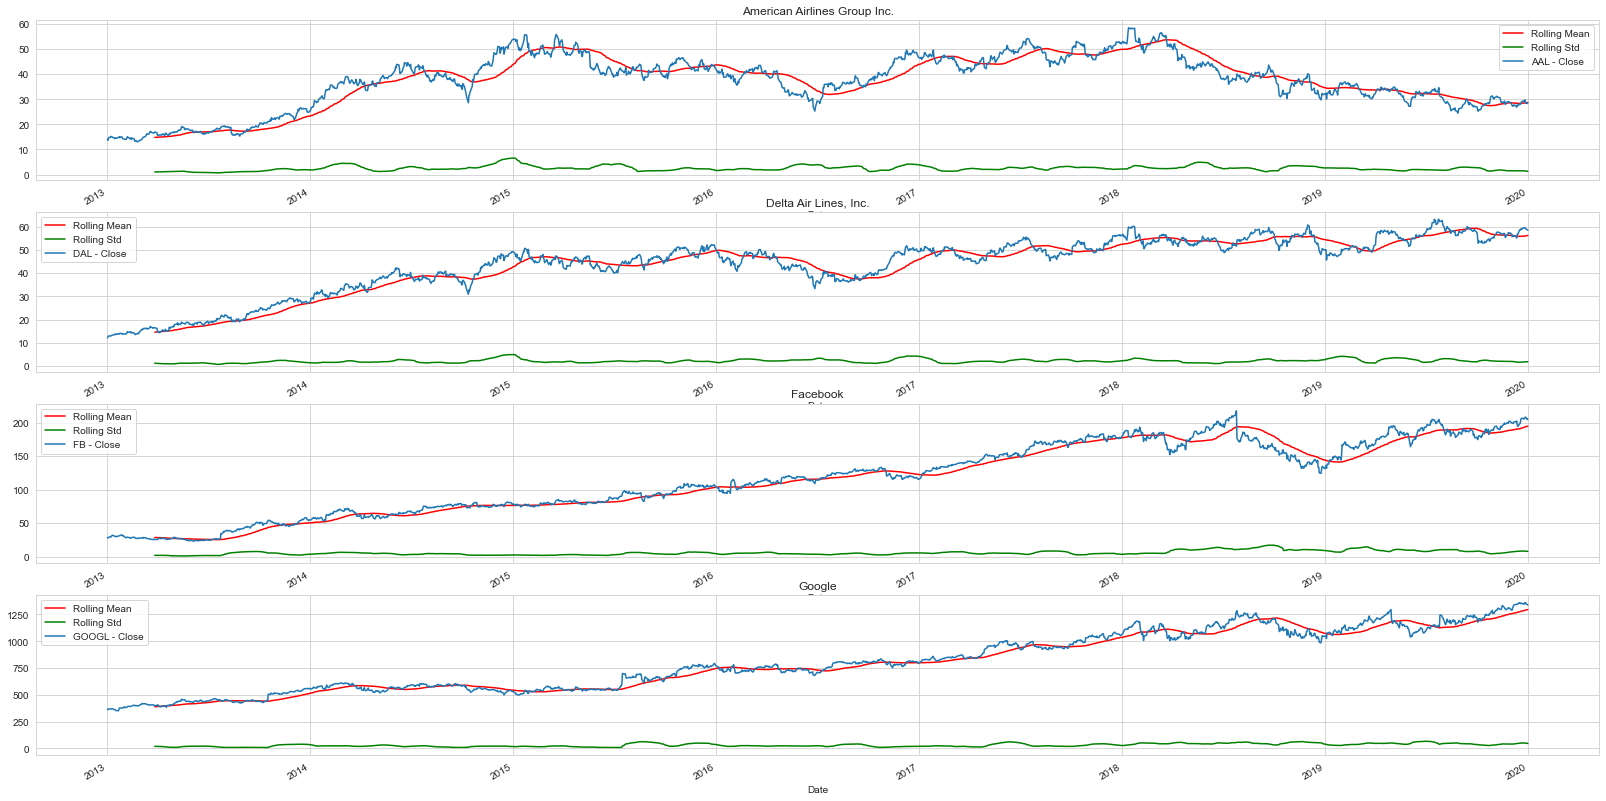

In [67]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss

# gives warning for kpss, p-value is smaller than indicated value in results below
warnings.filterwarnings("ignore")

def Get_Stationarity_Stats(feature = 'Close', period = 1):
    stats = pd.DataFrame(index=["Test", "ADF/Kpss", "p-value", "C-1%", "C-5%", "C-10%", "C-2.5%"])
    print("ADF - Null Hypothesis: Not Stationary")
    print("Kpss - Null Hypothesis: Stationary")

    fig, ax = plt.subplots(len(stocks), 1, figsize=(7*len(stocks), 15))
    for i, stock in enumerate(stocks):
        df_stock = globals()[stock] 

        rolling_mean = df_stock[feature].rolling(period).mean()
        rolling_std_dev = df_stock[feature].rolling(period).std()

        adf_test = adfuller(df_stock[feature])
        kpss_test = kpss(df_stock[feature], regression='c', store=False)

        ax[i].set_title(stock_names[stock])
        ax[i].plot(rolling_mean, color='r', label='Rolling Mean')
        ax[i].plot(rolling_std_dev, color='g', label='Rolling Std')
        df_stock.plot(y=[feature], ax=ax[i], label=[f"{stock} - {feature}"])
        ax[i].legend(loc='best')


        stats[f"{stock}-ADF"] = ["ADF", adf_test[0], adf_test[1], adf_test[4]['1%'], adf_test[4]['5%'], adf_test[4]['10%'], "-"]
        stats[f"{stock}-KPSS"] = ["KPSS", kpss_test[0], kpss_test[1], kpss_test[3]['1%'], kpss_test[3]['5%'], kpss_test[3]['10%'], kpss_test[3]['2.5%']]
    return stats

stationarity_stats = Get_Stationarity_Stats(period=60)
stationarity_stats

In [572]:
diffData = DAL-DAL.shift(2)
diffData.dropna(inplace=True)
adfuller(diffData['Close'], autolag='AIC')

(-11.443760742546543,
 6.088858951994535e-21,
 27,
 2486,
 {'1%': -3.4329831717881003,
  '5%': -2.8627033184297384,
  '10%': -2.5673892799386944},
 5295.174267055398)

TODO:
    p-values, what is correct?
    stationarity, shift by 1 and check adfuller and kpss
    add with twitter stock...

## Testing Stuff

Need To read up on this stuff.,..
- https://medium.com/quantjam/introduction-to-time-series-trend-decomposition-with-python-b54a29f8e038
- https://medium.com/quantjam/exploring-market-seasonality-trends-19a91381c0fe

<AxesSubplot:xlabel='Date'>

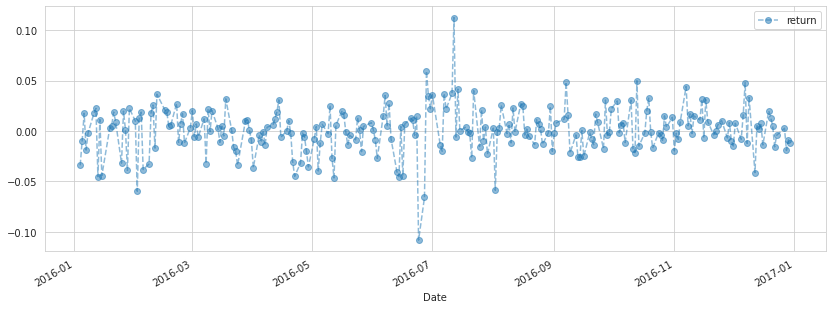

In [407]:
AAL2 = AAL.copy()
AAL2["return"] = AAL2["Close"].pct_change()
AAL2.loc[AAL2["Year"] == 2016]["return"].plot(figsize=(14,5),legend=True,linestyle='--',marker='o', alpha=0.5)

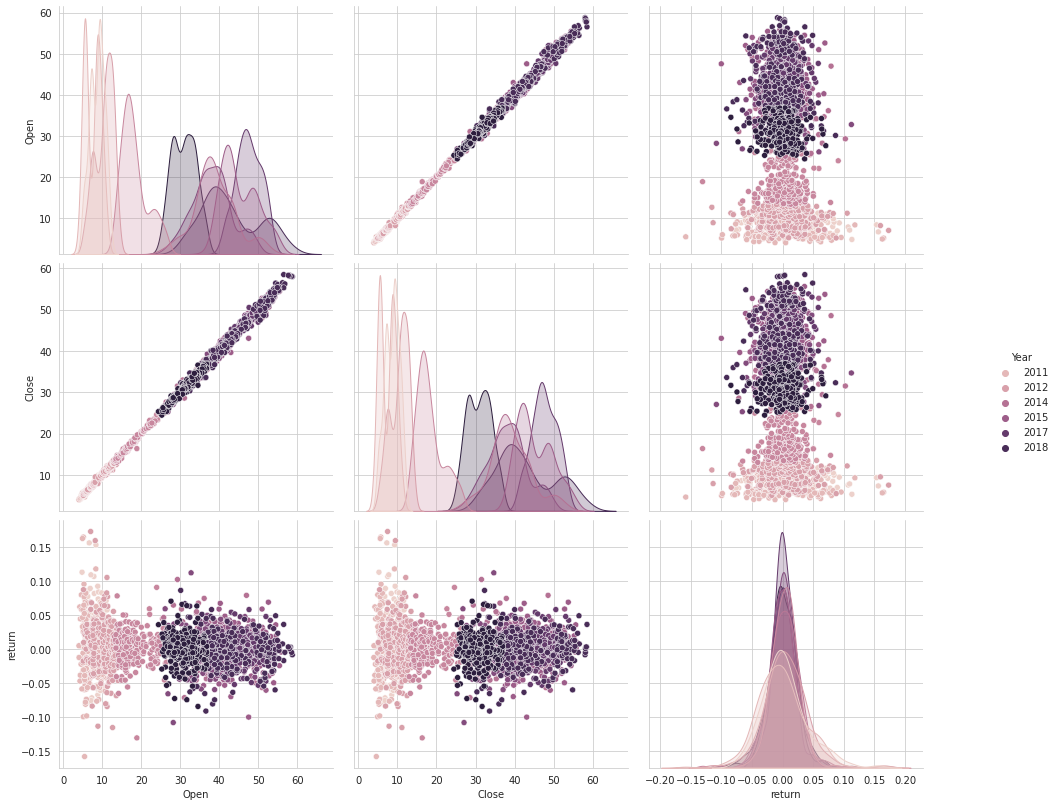

In [408]:
g = sns.pairplot(AAL2.dropna(), vars=["Open", "Close", "return"], kind="scatter", hue="Year")
g.fig.set_figwidth(15.27)
g.fig.set_figheight(11.7)

Stationary data? - https://towardsdatascience.com/forecasting-time-series-data-stock-price-analysis-324bcc520af5

In [409]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # # Plotting the statistics:
    # plt.figure(figsize=(24,6))
    # plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    # plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    # plt.plot(stock_close_price, color='red',label='Original Time Series')
    # plt.legend(loc='best')
    # plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("\nKPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(AAL['Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.683928
p-value: 0.439412
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 5.823907
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Looks like our data is not stationary, is this bad for arima?

In [410]:
test_period = period
test_period

251

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.450102
p-value: 0.128092
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.699399
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


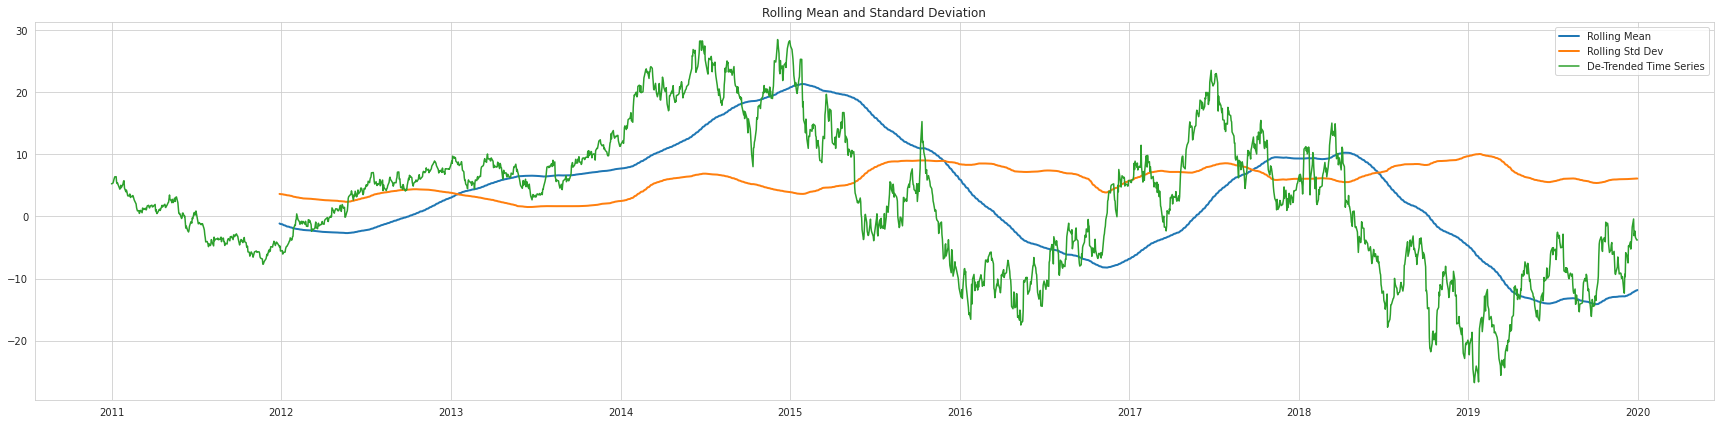

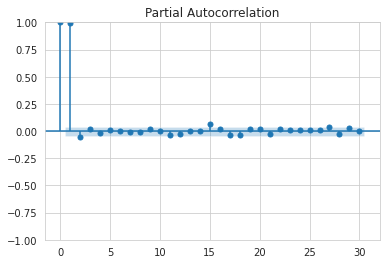

In [411]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
AAL['Close_Detrend'] = (AAL['Close'] - AAL['Close'].shift(test_period))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(test_period).mean()
    rolling_std_dev = stock_close_price.rolling(test_period).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(AAL['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(AAL['Close_Detrend'].dropna(), lags=30)

Save the stocks to csv file

In [358]:
def Save_Stock_Data(path="data/"):
    for stock in stocks:
        df_stock = globals()[stock]
        df_stock.to_csv(f"{path}{stock}.csv")
Save_Stock_Data()